###### I discussed this problem with Zihao Li and Daniel Tang 

### Pre-processing the data

In [1]:
import numpy as np
np.random.seed(801214)

data = np.float64(np.load('MNIST.npy'))
labels = np.float32(np.load('MNIST_labels.npy'))
data = np.array(data)/255
labels = np.array([labels])

In [2]:
data_mat = np.concatenate((data,np.transpose(labels)),axis=1)
# Splitting into training, development, and testing data 
np.random.shuffle(data_mat)
[train,develop,test] = np.split(data_mat[:,0:784],[int(0.6*70000),int(0.8*70000)])
[train_label,develop_label,test_label] = np.split(data_mat[:,-1],[int(0.6*70000),int(0.8*70000)])

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
def display_image(image):
    pixels = image.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    plt.axis('off')

## Part 1: PCA
### (a) Extract principal components

In [4]:
# Because the columns are already at the same scale, no need to standardize, but we do need to center the data 
from sklearn import preprocessing
standardize_train = preprocessing.scale(train)
# Do SVD on centered data
u,s,vt = np.linalg.svd(standardize_train,full_matrices=False)
#The first 10 principal components are the first 10 columns of V 
top10_pcs = np.transpose(vt)[:,0:10]

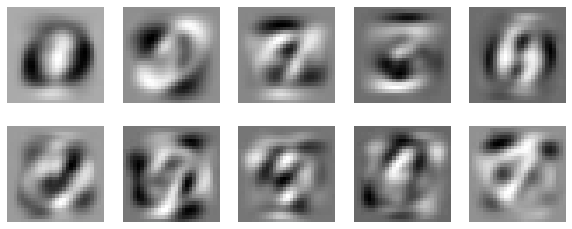

In [5]:
# Visualizing the first 10 principal components as images:
plt.figure(figsize=(10, 4)) 
for i in range(10):
    plt.subplot(2,5,i+1)
    display_image(top10_pcs[:,i])
plt.show()

### (b) Plot variance

The variance of principal components are the corresponding eigenvalues, which correspond to singular values by the equation: $\lambda_{i} = s_{i}/(n-1)$.

In [6]:
variances = s / (70000-1)

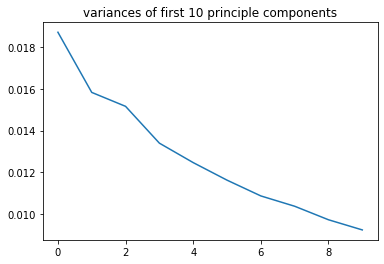

In [7]:
plt.plot(variances[0:10])
plt.title("variances of first 10 principle components")
plt.show()

### (c) Dimension reduction

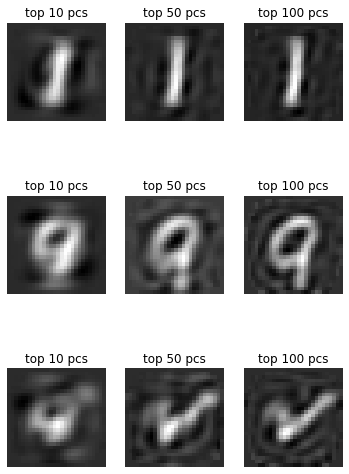

In [8]:
train_mean = np.mean(train,axis=0)
def project_to_m_pcs(data_indexes,m):
    i = 0
    plt.figure(figsize=(len(m)*2,len(data_indexes)*3))
    for index in data_indexes:
        data = test[index]
        for number_pc in m:
            projection_matrix = np.matmul(vt[0:number_pc].T,vt[0:number_pc])
            projection = np.matmul(projection_matrix, data-train_mean) + train_mean
            plt.subplot(len(data_indexes),len(m),i+1)
            display_image(projection)
            plt.title("top "+str(number_pc)+" pcs")
            i = i+1
    plt.show()

project_to_m_pcs([0,15,120],[10,50,100])    

I tried projecting 3 random data points on the first 10, 50, and 100 principle components. In general,the digits become clearer and clearer as you project onto subspace spanned by more and more principle components, because more of the variation in data is captured. For some data points, the first few principle components are enough to capture most of the features of data, but for others, the image only becomes clearer after 100 pcs. There is no clear interpreation of the principle components, but it seems that the top principal components captures the white space (the cantor) of the image pretty well. 

## Part 2: K-means

In [9]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10,n_init=2,max_iter=20)
model.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=20,
       n_clusters=10, n_init=2, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

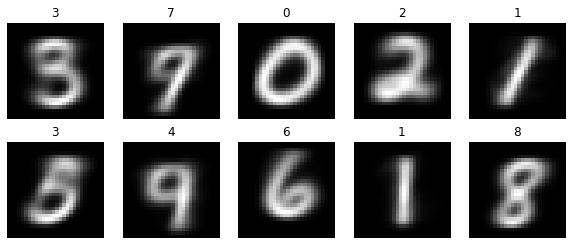

In [10]:
# Showing the center of clusters, 
# and evaluating how closely the clusters capture the structure of the data
# by associating each cluster with the majority label
centers = model.cluster_centers_
labels = model.labels_
cluster_label_scores = np.zeros((10,10))
for i in range(42000):
    cluster_label_scores[labels[i],int(train_label[i])] += 1
center_label = np.argmax(cluster_label_scores,axis=1)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    display_image(centers[i])
    plt.title(str(center_label[i]))
plt.show()

The centers for K-means with 10 clusters are displayed above along with the most common label around each cluster. It seems that the algorithm has some trouble distinguishing between 4,7,and 9, as wel as 3 and 5,but in general the classification done by each cluster is quite accurate. 

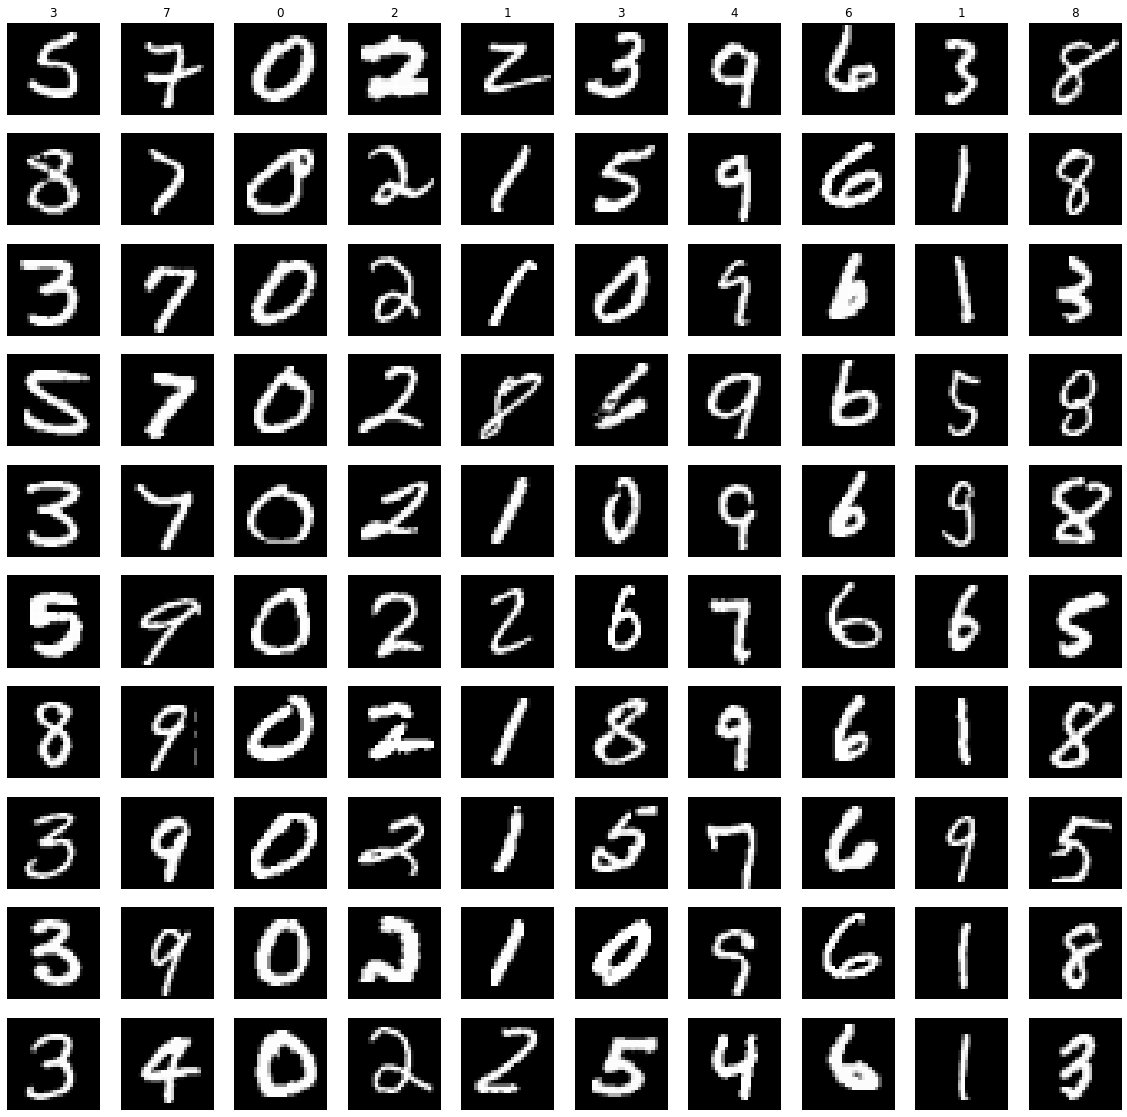

In [11]:
# Construct plots showing samples of the digits from each cluster
# comment on how well the clusters respect the true digit labels

plt.figure(figsize=(20,20))
for i in range(10):
    temp = train[model.labels_==i]
    for j in range(10):
        plt.subplot(10,10,j*10+i+1)
        display_image(temp[j])
        if j==0:
            plt.title(str(center_label[i]))
plt.show()

From the result, we see that clusters with most common labels such as 2 and 0 are mostly consistent. However,it is difficult for the algorithm to distinguish between 4,7,9 trio and sometimes 3,5,8 trio.

## Part 3: Spectral Clustering
### (a)

In [13]:
# construct the similarity matrix A by applying Gaussian kernel to squared distance.
# Pick bandwidth in range of 10 to 30

def gaussian_kernel(xi,xj,h):
    wij = np.exp((-(np.linalg.norm(xi-xj))**2)/h)
    return(wij)

def create_similarity_matrix(data,h):
    n = data.shape[0]
    similarity_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i,j] = gaussian_kernel(data[i],data[j],h)
    return(similarity_matrix)

def create_graph_laplacian(W):
    n = W.shape[0]
    D = np.zeros((n,n))
    for i in range(n):
        D[i,i] = np.sum(W[:,i])
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    W_tilde = np.matmul(np.matmul(D_sqrt_inv,W),D_sqrt_inv)
    L = np.identity(n) - W_tilde
    return(L)

# I will define the functions first in this part and optimize for bandwidth h in the next part. 

### (b)

In [14]:
train_spectral = train[0:3000] # use the first 3000 data points in training set
W = create_similarity_matrix(train_spectral,20) 
# I pick h=20, the average in the suggested range for bandwidth. 
# The result when h=20 looks fine, so I will not do cross validation to select for h
# as it does not affect the analysis much. 
L = create_graph_laplacian(W)
w,v = np.linalg.eigh(L)

#### step1: compute the bottom few eigenvectors of L except the lowest one:

In [15]:
bottom_two_eigvec= v[:,[1,2]]
print(bottom_two_eigvec)

[[ 0.00523954 -0.01828829]
 [ 0.00185521 -0.00417446]
 [-0.00404041 -0.00744546]
 ...
 [ 0.00570749 -0.01802791]
 [ 0.00072771 -0.00421781]
 [ 0.04709503  0.0477844 ]]


#### step 2: run K-means with r=2, show a scatter plot of the first 3 digits 0,1,2 embedded with v2 and v3

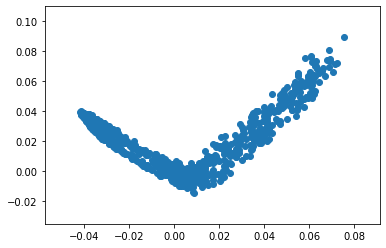

In [16]:
def embedding(v,r_indices,data_indices):
    v_components = v[:,r_indices[0]:r_indices[-1]]
    embeddings = v_components[data_indices]
    return(embeddings)

label_spectral = train_label[0:3000]
data_indices = np.argwhere(label_spectral<3).flatten()
r_indices = [1,3]
spectral_projections = embedding(v,r_indices,data_indices)

import pylab as py
py.scatter(spectral_projections[:,0],spectral_projections[:,1])

In [17]:
def show_clusters(kmeans,X):# from previous homework
    y=kmeans.predict(X)
    fig=py.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(X[:,0],X[:,1],'o',color='blue')
    for i in range(2):
        ec=[0.,0.,0.,1.]
        ec[i]=1.
        ax.plot(X[y==i,0],X[y==i,1],'o',markerfacecolor=(1.,1.,1.,0), markeredgecolor=ec,markersize=10)
    ax.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'o',color='black',markersize=15)

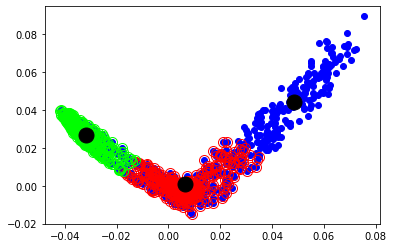

In [18]:
import pylab as py
model_spectral = KMeans(n_clusters = 3)
model_spectral.fit(spectral_projections)
show_clusters(model_spectral,spectral_projections)

From the cluster plot, we see that there is a nice separation into three clusters corresponding to the three digits 0,1,2.

### (c): Continuous extension of the embedding

In [19]:
W_sums = np.sum(W,axis=0) 

In [20]:
def embedding_continuous(x,data,h):
    n = data.shape[0]
    embeddings = np.zeros(2)
    kernels = np.zeros(3000)
    for i in range(3000):
        kernels[i] = gaussian_kernel(x,data[i],h)
    weight1 = np.sum(kernels)
    for i in range(n):
        embeddings[0] += kernels[i] / np.sqrt(weight1*W_sums[i]) * v[i,1]
        embeddings[1] += kernels[i] / np.sqrt(weight1*W_sums[i]) * v[i,2]
    embeddings[0] = embeddings[0] / w[1]
    embeddings[1] = embeddings[1] / w[2]
    return(embeddings)

In [47]:
# Now write a function to compute the continuous extension of the embedding onto v2, v3, and then
# take a sample of 0's that wasn't in the training set and show where they are embedded relative to the 
# other 0's. 
test_label_spectral = test_label[0:1000]
data_indices_test = np.argwhere(test_label_spectral==0).flatten()
test_spectral = test[data_indices_test]
spectral_projections_continuous = np.zeros((test_spectral.shape[0],2))
for i in range(test_spectral.shape[0]):
    spectral_projections_continuous[i] = embedding_continuous(test_spectral[i],train_spectral,20)

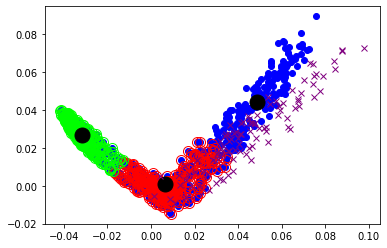

In [49]:
y=model_spectral.predict(spectral_projections)
fig=py.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(spectral_projections[:,0],spectral_projections[:,1],'o',color='blue')
for i in range(2):
    ec=[0.,0.,0.,1.]
    ec[i]=1.
    ax.plot(spectral_projections[y==i,0],spectral_projections[y==i,1],'o',markerfacecolor=(1.,1.,1.,0), markeredgecolor=ec,markersize=10)
ax.plot(model_spectral.cluster_centers_[:,0],model_spectral.cluster_centers_[:,1],'o',color='black',markersize=15)
ax.plot(spectral_projections_continuous[:,0],spectral_projections_continuous[:,1],'x',color='purple')

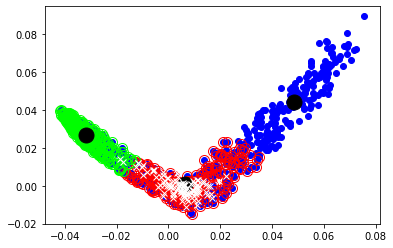

In [51]:
test_label_spectral = test_label[0:1000]
data_indices_test = np.argwhere(test_label_spectral==2).flatten()
test_spectral = test[data_indices_test]
spectral_projections_continuous = np.zeros((test_spectral.shape[0],2))
for i in range(test_spectral.shape[0]):
    spectral_projections_continuous[i] = embedding_continuous(test_spectral[i],train_spectral,20)

y=model_spectral.predict(spectral_projections)
fig=py.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(spectral_projections[:,0],spectral_projections[:,1],'o',color='blue')
for i in range(2):
    ec=[0.,0.,0.,1.]
    ec[i]=1.
    ax.plot(spectral_projections[y==i,0],spectral_projections[y==i,1],'o',markerfacecolor=(1.,1.,1.,0), markeredgecolor=ec,markersize=10)
ax.plot(model_spectral.cluster_centers_[:,0],model_spectral.cluster_centers_[:,1],'o',color='black',markersize=15)
ax.plot(spectral_projections_continuous[:,0],spectral_projections_continuous[:,1],'x',color='white')

We see that with continuous extension of spectral clustering on the second and third eigenvectors, sometimes data with label 0 is misclassified as label 2, but rarely as 1, which makes sense since both 0 and 2 are curly, indicating that the first few eigenvectors may be capturing the curliness of the digits. However, for test data with label 2, it is rarely if never misclassified as label 0. This may be due to the fact that there are more variability in the way digit 0 is drawn than in the way digit 2 is drawn.

## Part 4: Classification

### (a): Training multi-class classification model on pixel data

In [52]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(fit_intercept=True, C=100000,penalty='l2',multi_class='multinomial',solver='lbfgs',max_iter=150)
model = lg.fit(train,train_label)
validation_prediction = model.predict(develop)
print(1-np.sum(validation_prediction==develop_label)/14000)

0.08385714285714285


The validation error is about 8.3%.

### (b): Training multi-class classification model on principle components

In [53]:
train_mean = np.mean(train,axis=0)
def project_onto_k_pcs(data,k):
    n = data.shape[0]
    scores = np.zeros(data.shape)
    projection_matrix = np.matmul(vt[0:k].T,vt[0:k])
    for i in range(n):
        point = data[i]
        projection = np.matmul(projection_matrix, point-train_mean) + train_mean
        scores[i,:] = projection
    return(scores)

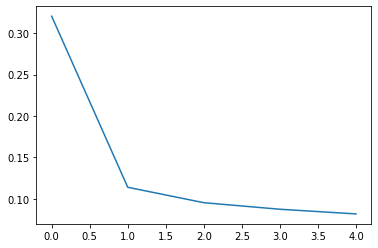

In [54]:
validation_errors = []
n = develop.shape[0]
for k in range(5,100,20):
    train_projections = project_onto_k_pcs(train,k)
    develop_projections = project_onto_k_pcs(develop,k)
    model = lg.fit(train_projections,train_label)
    develop_predictions = model.predict(develop_projections)
    validation_errors.append(1-np.sum(develop_predictions==develop_label)/n)
plt.plot(validation_errors)

We see that the error decreases as the number of principle components increases. I limited the max number of pcs used to 100, but if more are used, the model may start picking up on noises and see error increasing. 

### (c): Compare PC and raw data model

In [55]:
# Using PCA
k_star = list(range(5,100,20))[np.argmin(validation_errors)]
augmented_data = np.concatenate((train,develop),axis=0)
augmented_label = np.concatenate((train_label,develop_label),axis=0)
projected_augmented_data = project_onto_k_pcs(augmented_data,k_star)
projected_test = project_onto_k_pcs(test,k_star)
model = lg.fit(projected_augmented_data,augmented_label)
test_predictions = model.predict(projected_test)
1-np.sum(test_predictions==test_label)/test.shape[0]

0.08371428571428574

In [56]:
# Raw features
model = lg.fit(augmented_data,augmented_label)
test_predictions = model.predict(test)
1-np.sum(test_predictions==test_label)/test.shape[0]

0.08107142857142857

The testing error for the two models are qute similar, although the raw features model performs just slightly better. The choice of my optimal k_star is not entirely perfect,since I have limited the total number of principle components that are used. If I have allowed more principle components to be included as covariates, the prediction error may go down even further. 